In [7]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.cluster import *
from sklearn.mixture import GaussianMixture
import pandas as pd
import seaborn as sns

cudnn.benchmark = True
plt.ion()  

In [8]:
model = models.resnet18()
model.fc = nn.Identity()
model.load_state_dict(torch.load('model_resnet18.pth',map_location=torch.device('cuda:0')))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../dataset/split-images-lr'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
images_all = None
labels_all = None
for images, labels in dataloaders['test']:
    labels = labels.numpy()
    if labels_all is None:
        labels_all = labels
    else:
        labels_all = np.concatenate((labels_all, labels))
    outputs = model(images).detach().cpu().numpy()
    if images_all is None:
        images_all = outputs
    else:
        images_all = np.concatenate((images_all, outputs)) 

In [6]:
pd.DataFrame(images_all).to_csv('model_resnet18_images_features.csv')

In [11]:
db = DBSCAN(eps=3.0, ).fit(images_all)
pred_18 = db.labels_
print(db.labels_.shape)
accuracy_18 = {}
accuracy_18['normalized_mutual_info_score'] = normalized_mutual_info_score(labels_all, pred_18)
accuracy_18['rand_score'] = rand_score(labels_all, pred_18)
accuracy_18['completeness_score'] = completeness_score(labels_all, pred_18)
accuracy_18['fowlkes_mallows_score'] = fowlkes_mallows_score(labels_all, pred_18)

(14198,)


{'normalized_mutual_info_score': 0.0, 'rand_score': 0.033512037063872804, 'completeness_score': 1.0, 'fowlkes_mallows_score': 0.18306293197660964}


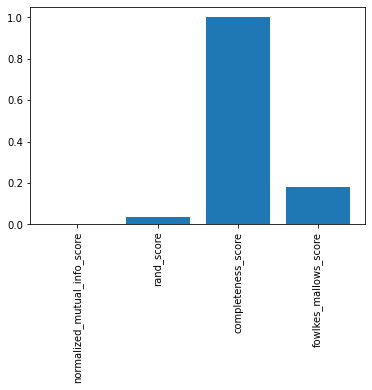

In [8]:
fig, ax = plt.subplots()
ax.bar(list(accuracy_18.keys()), list(accuracy_18.values()))
ax.tick_params(axis='x', labelrotation=90)
print(accuracy_18)

In [12]:
model_34 = models.resnet34()
model_34.fc = nn.Identity()
model_34.load_state_dict(torch.load('model_resnet34.pth'))
model_34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
images_all_34 = None
labels_all_34 = None
for images, labels in dataloaders['test']:
    labels = labels.numpy()
    if labels_all_34 is None:
        labels_all_34 = labels
    else:
        labels_all_34 = np.concatenate((labels_all_34, labels))
    outputs = model_34(images).detach().cpu().numpy()
    if images_all_34 is None:
        images_all_34 = outputs
    else:
        images_all_34 = np.concatenate((images_all_34, outputs)) 

In [14]:
pd.DataFrame(images_all_34).to_csv('model_resnet34_images_features.csv')

In [18]:
db_34 = DBSCAN().fit(images_all_34)
pred_34 = db_34.labels_
accuracy_34 = {}
accuracy_34['normalized_mutual_info_score'] = normalized_mutual_info_score(labels_all_34, pred_34)
accuracy_34['rand_score'] = rand_score(labels_all_34, pred_34)
accuracy_34['completeness_score'] = completeness_score(labels_all_34, pred_34)
accuracy_34['fowlkes_mallows_score'] = fowlkes_mallows_score(labels_all_34, pred_34)

{'normalized_mutual_info_score': 0.0, 'rand_score': 0.033512037063872804, 'completeness_score': 1.0, 'fowlkes_mallows_score': 0.18306293197660964}


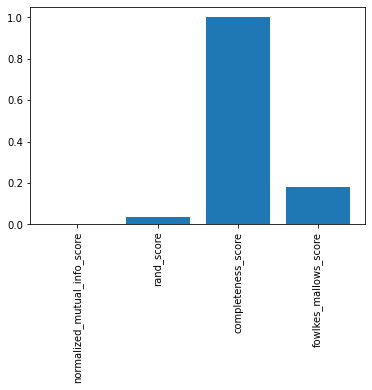

In [19]:
fig, ax = plt.subplots()
ax.bar(list(accuracy_34.keys()), list(accuracy_34.values()))
ax.tick_params(axis='x', labelrotation=90)
print(accuracy_34)

In [15]:
model_50 = models.resnet50()
model_50.fc = nn.Identity()
model_50.load_state_dict(torch.load('model_resnet50.pth'))
model_50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
images_all_50 = None
labels_all_50 = None
for images, labels in dataloaders['test']:
    labels = labels.numpy()
    if labels_all_50 is None:
        labels_all_50 = labels
    else:
        labels_all_50 = np.concatenate((labels_all_50, labels))
    outputs = model_34(images).detach().cpu().numpy()
    if images_all_50 is None:
        images_all_50 = outputs
    else:
        images_all_50 = np.concatenate((images_all_50, outputs)) 

In [17]:
pd.DataFrame(images_all_50).to_csv('model_resnet50_images_features.csv')

In [21]:
db_50 = DBSCAN().fit(images_all_50)
pred_50 = db_50.labels_
accuracy_50 = {}
accuracy_50['normalized_mutual_info_score'] = normalized_mutual_info_score(labels_all_50, pred_50)
accuracy_50['rand_score'] = rand_score(labels_all_50, pred_50)
accuracy_50['completeness_score'] = completeness_score(labels_all_50, pred_50)
accuracy_50['fowlkes_mallows_score'] = fowlkes_mallows_score(labels_all_50, pred_50)

{'normalized_mutual_info_score': 0.0, 'rand_score': 0.033512037063872804, 'completeness_score': 1.0, 'fowlkes_mallows_score': 0.18306293197660964}


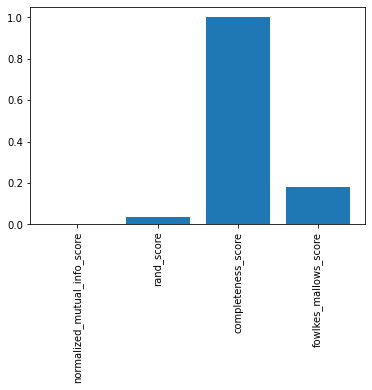

In [22]:
fig, ax = plt.subplots()
ax.bar(list(accuracy_50.keys()), list(accuracy_50.values()))
ax.tick_params(axis='x', labelrotation=90)
print(accuracy_50)

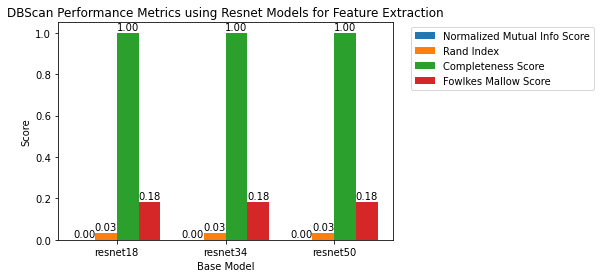

In [23]:
labels = ['resnet18', 'resnet34', 'resnet50']
normal = [accuracy_18['normalized_mutual_info_score'], accuracy_34['normalized_mutual_info_score'], accuracy_50['normalized_mutual_info_score']]
rand = [accuracy_18['rand_score'], accuracy_34['rand_score'], accuracy_50['rand_score']]
complete = [accuracy_18['completeness_score'], accuracy_34['completeness_score'], accuracy_50['completeness_score']]
fowlkes = [accuracy_18['fowlkes_mallows_score'], accuracy_34['fowlkes_mallows_score'], accuracy_50['fowlkes_mallows_score']]
x = np.arange(len(labels))
width=0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x-3*width/2, normal, width, label='Normalized Mutual Info Score')
rects2 = ax.bar(x-width/2, rand, width, label='Rand Index')
rects3 = ax.bar(x+width/2, complete, width, label='Completeness Score')
rects4 = ax.bar(x+3*width/2, fowlkes, width, label='Fowlkes Mallow Score')
ax.set_ylabel('Score')
ax.set_xlabel('Base Model')
ax.set_title('DBScan Performance Metrics using Resnet Models for Feature Extraction')

ax.bar_label(rects1, padding=1, fmt='%.2f')
ax.bar_label(rects2, padding=1, fmt='%.2f')
ax.bar_label(rects3, padding=1, fmt='%.2f')
ax.bar_label(rects4, padding=1, fmt='%.2f')
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_xticks(x, labels)
fig.patch.set_facecolor('white')